# Reinforcement learning

In this exercise, we will be working with OpenAI Gym, which is an open-source interface designed for reinforcement learning tasks. Its main advantage is that implementing various types of reinforcement learning algorithms in it is quite straightforward. A description of the basic functions of OpenAI Gym can be found in the code below.

Today's task will be to implement an agent that learns to behave in an environment (specifically in MountainCar) using Q-learning.

Q-learning is a method where the agent learns its strategy for behaving in a given environment using feedback it receives from the environment for its actions. Unlike a greedy agent, which simply chooses a new state in each state based on the action that maximizes its utility, it takes into account that there are relationships between states that are given by the Bellman equations.

Now, let's take a look at an example of a car trying to reach a goal but moving randomly.

In [2]:
import gymnasium as gym
import numpy as np
import utils
import matplotlib.pyplot as plt

Below, we create a simple environment called *MountainCar*: https://gym.openai.com/envs/MountainCar-v0. 

The goal is to make the car reach the flag, starting in the valley below. In this basic version, we sample a random action in each step. Actions are go left, right or do not accelerate.

In [ ]:
from utils import init_render, plot_step

env = gym.make('MountainCar-v0', render_mode="rgb_array")
env.reset()

img = init_render(env)

for i in range(1000):
    plot_step(env, img)
    env.step(env.action_space.sample()) # take a random action

env.close()

Just to give another example, a different toy environment is *CartPole*, where we balance a pole so that it does not fail.

Interrupted


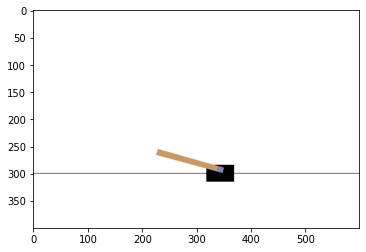

In [8]:
from utils import init_render, plot_step

env = gym.make('CartPole-v1', render_mode="rgb_array")
env.reset()

img = init_render(env)

try:
    for _ in range(1000):
        plot_step(env, img)
        env.step(env.action_space.sample()) # take a random action
except KeyboardInterrupt:
    print('Interrupted')

env.close()

Let's go back to MountainCar. We'll implement a class for an agent that behaves randomly. **This can be used as a basis for a reinforcement learning agent (in the Q learning task).**

The agent's state consists of position and velocity, and its actions are move left, move right, or stay still. We will repeat several iterations - *episodes* - for training. Each episode represents a new random start in the valley (middle of x position, 0 velocity). Within the while loop, we'll learn from transitions between the agent's states using actions.

In [4]:
import importlib
importlib.reload(utils)
import utils

In [4]:
from solution import QLearningAgent, StateDiscretizer

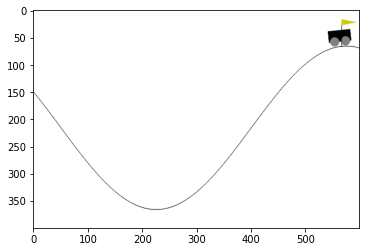

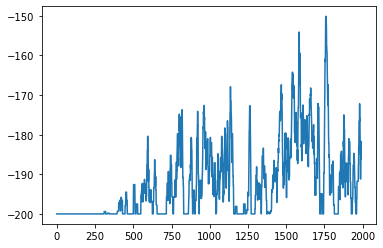

In [6]:
from tqdm import tqdm

# Obecna trida pro agenta
class RandomAgent:
    def __init__(self, actions):
        self.actions = actions
        self.train = True
    
    def act(self, observe, reward, done):
        return self.actions.sample()
    
    def reset(self):
        pass

env = gym.make('MountainCar-v0', render_mode="rgb_array")

# Zde si jen pro zajimavost vypiseme prostor pozorovani a akci
print('observation space:', env.observation_space)
print('observation space low:', env.observation_space.low)
print('observation space high:', env.observation_space.high)
print('action space:', env.action_space, flush=True)


st = StateDiscretizer(list(zip(env.observation_space.low, env.observation_space.high)), [15, 15])

#agent = RandomAgent(env.action_space)
agent = QLearningAgent(env.action_space, st, train=True)
total_rewards = []
for i in tqdm(range(2000)):
    obs, info = env.reset()
    agent.reset()    
    truncated = False
    terminated = False
    
    r = 0
    R = 0 # total reward - just for logging
    t = 0 # step count - just for logging
    
    # terminated ... found final state; truncated ... usually time limit
    # sometimes instead (done, terminated) in code - there was an api change :(
    while not (terminated or truncated):
        action = agent.act(obs, r, terminated or truncated)
        obs, r, terminated, truncated, _ = env.step(action)
        R += r
        t += 1
        
    total_rewards.append(R)    
agent.train = False

# Plot animation and learning scheme
plt.figure()

try:
    env.reset()
    agent.train = False
    utils.show_animation(agent, env, steps=200, episodes=5)
except KeyboardInterrupt:
    print('interrupted')
finally:
    plt.show()

plt.plot(utils.moving_average(total_rewards, 10))
plt.show() 

env.close()

## Exercise Task
Try to implement a class of an agent that learns to solve the MountainCar environment using Q-learning (in place of the random agent). Be mindful that the environment returns continuous state values, so you **need to discretize them** (i.e., have a finite number of states). You can use `np.linspace` and `np.digitize` for this purpose. Notice that you have two continuous actions - try to handle it as a cartesian product to get one value for the state matrix.

Try to implement the solution in a file named q_agent.py and import its class just like in utils.py.

## Data analysis of the Q agent

Looking at max Q values, some states are 0 while some are negative. 0 probably means that the agent did not visit these states. 

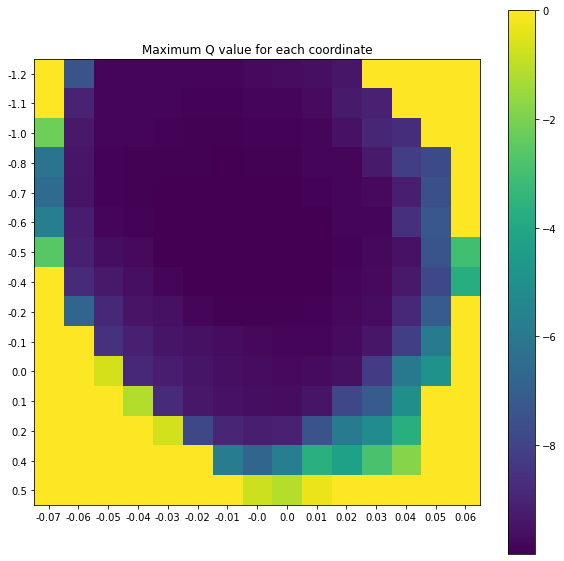

In [76]:
# let's look at max values of Q
plt.figure(figsize=(10, 10))
plt.title("Maximum Q value for each coordinate")
plt.imshow(agent.Q.max(axis=1).reshape(15, 15))
plt.xticks(np.arange(15), st.bins[1].round(2).tolist()[:-1])
plt.yticks(np.arange(15), st.bins[0].round(1).tolist()[:-1])
plt.colorbar()
plt.show()

Looking at standard deviation, the biggest variance is in states where agent has a larger velocity (especially to the right). Some action will be better than the other actions in these states.

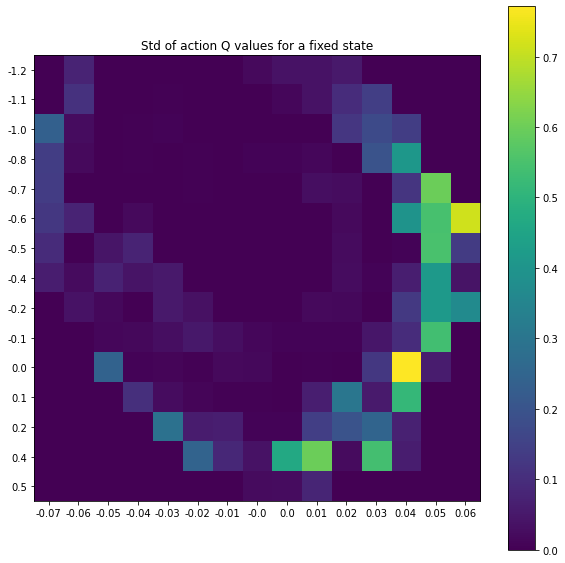

In [78]:
plt.figure(figsize=(10, 10))
plt.title("Std of action Q values for a fixed state")
plt.imshow(agent.Q.std(axis=1).reshape(15, 15))
plt.xticks(np.arange(15), st.bins[1].round(2).tolist()[:-1])
plt.yticks(np.arange(15), st.bins[0].round(1).tolist()[:-1])
plt.colorbar()
plt.show()

In terms of action preferences, if the agent has a high velocity to the right, we want it to continue accelerating to the right (yellow). On the other hand, if it has a higher velocity to the left, we want it to neither accelerate nor switch to the right (turquoise), or even to move to the right (yellow). It should only move to the left in a few cases (dark blue).

When you observe the agent, it tends to first go uphill to the right, and then use the downward acceleration for leftward movement. Then, it uses the left hill to go up to the flag. We can take another look at one episode (displaying the current chosen action in the title).

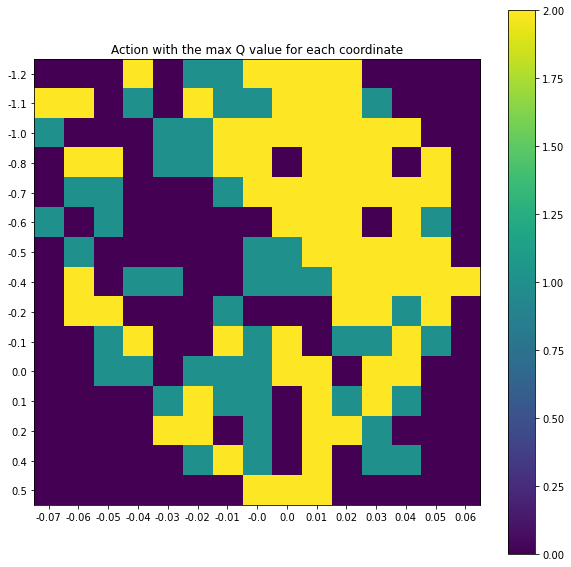

In [7]:
# 2 ... go right, 1 ... stay, 0 ... go left
# Left side 
plt.figure(figsize=(10, 10))
plt.title("Action with the max Q value for each coordinate")
plt.imshow(agent.Q.argmax(axis=1).reshape(15, 15))
plt.xticks(np.arange(15), st.bins[1].round(2).tolist()[:-1])
plt.yticks(np.arange(15), st.bins[0].round(1).tolist()[:-1])
plt.colorbar()
plt.show()

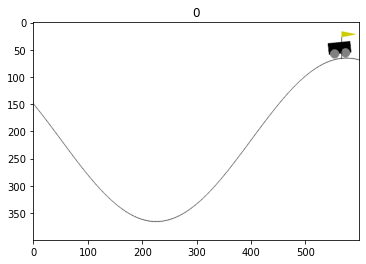

In [10]:
obs, info = env.reset()
agent.reset()    
done = False
terminated = False

r = 0
R = 0 # celkova odmena - jen pro logovani
t = 0 # cislo kroku - jen pro logovani

img = init_render(env)
while not (done or terminated):
    plot_step(env, img)
    action = agent.act(obs, r, done or terminated)
    # in docs, different naming
    obs, r, done, terminated, _ = env.step(action)  # done ... nasel finalni stav; terminated ... skoncil driv
    R += r
    t += 1
    plt.title(action)